### Events EDA

In [60]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType, ArrayType, BooleanType
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
spark = SparkSession.builder \
    .appName("Events EDA") \
    .config("spark.jars", "gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar") \
    .getOrCreate()

In [37]:
raw_events_df = spark.read.parquet("gs://msca-bdp-student-gcs/Group_1_final_project/parquet_versions/events_parquet/")
events_df = spark.read.parquet("gs://msca-bdp-student-gcs/Group_1_final_project/curated/events_curated")

In [38]:
total_count = raw_events_df.count()
unique_count = raw_events_df.select('Event_ID').distinct().count()
print(f"\nTotal records: {total_count}")
print(f"Unique events: {unique_count} (removed {total_count - unique_count} duplicates)")


Total records: 12645998
Unique events: 99177 (removed 12546821 duplicates)


In [39]:
events_unique = raw_events_df.dropDuplicates(['Event_ID'])

**Events by Borough**

In [40]:
print(f"\nEvents by Borough:")
borough_counts = events_unique.groupBy('event_borough') \
    .agg(F.count('*').alias('count')) \
    .orderBy(F.col('count').desc())
borough_counts.show()


Events by Borough:


+-------------+-----+
|event_borough|count|
+-------------+-----+
|    Manhattan|39342|
|     Brooklyn|24550|
|       Queens|20903|
|        Bronx|10620|
|Staten Island| 3762|
+-------------+-----+



**Top 10 Event Names**

In [41]:
print(f"\nTop 10 Event Names:")
event_name_counts = events_unique.groupBy('Event_Name') \
    .agg(F.count('*').alias('count')) \
    .orderBy(F.col('count').desc()) \
    .limit(10)
event_name_counts.show(truncate=False)


Top 10 Event Names:


+---------------------------------------+-----+
|Event_Name                             |count|
+---------------------------------------+-----+
|Soccer - Non Regulation                |10211|
|Celebration                            |7790 |
|Party                                  |6293 |
|Miscellaneous                          |5717 |
|Soccer -Regulation                     |4658 |
|Softball - Adults                      |4216 |
|Picnic                                 |3820 |
|Barbecue                               |2390 |
|Baseball - 12 and Under (Little League)|2178 |
|Basketball                             |1514 |
+---------------------------------------+-----+



In [42]:
print(f"\nEvents by Agency:")
agency_counts = events_unique.groupBy('Event_Agency') \
    .agg(F.count('*').alias('count')) \
    .orderBy(F.col('count').desc())
agency_counts.show()


Events by Agency:


+--------------------+-----+
|        Event_Agency|count|
+--------------------+-----+
|    Parks Department|81553|
|Street Activity P...|15010|
|   Police Department| 1953|
|Mayor's Office of...|  401|
|Mayor's Office of...|  134|
|Hudson River Park...|  126|
+--------------------+-----+



In [43]:
events_unique = events_unique.withColumn(
    'Start_Date_Time',
    F.to_timestamp(F.col('Start_Date_Time'), 'MM/dd/yyyy hh:mm:ss a')
).withColumn(
    'End_Date_Time',
    F.to_timestamp(F.col('End_Date_Time'), 'MM/dd/yyyy hh:mm:ss a')
).withColumn(
    'Duration_Hours',
    (F.unix_timestamp('End_Date_Time') - F.unix_timestamp('Start_Date_Time')) / 3600
).withColumn(
    'Month',
    F.month('Start_Date_Time')
).withColumn(
    'Day_of_Week_Num',
    F.dayofweek('Start_Date_Time')
).withColumn(
    'Day_of_Week',
    F.expr("CASE WHEN dayofweek(Start_Date_Time) = 1 THEN 'Sunday' " +
         "WHEN dayofweek(Start_Date_Time) = 2 THEN 'Monday' " +
         "WHEN dayofweek(Start_Date_Time) = 3 THEN 'Tuesday' " +
         "WHEN dayofweek(Start_Date_Time) = 4 THEN 'Wednesday' " +
         "WHEN dayofweek(Start_Date_Time) = 5 THEN 'Thursday' " +
         "WHEN dayofweek(Start_Date_Time) = 6 THEN 'Friday' " +
         "WHEN dayofweek(Start_Date_Time) = 7 THEN 'Saturday' END")
).withColumn(
    'Hour',
    F.hour('Start_Date_Time')
).withColumn(
    'Date',
    F.col('Start_Date_Time').cast('date')
)

In [44]:
events_unique.cache()

DataFrame[Event_ID: int, Event_Name: string, Start_Date_Time: timestamp, End_Date_Time: timestamp, Event_Agency: string, Event_Type: string, Event_Borough: string, Event_Location: string, Event_Street_Side: string, Street_Closure_Type: string, Community_Board: string, Police_Precinct: string, Duration_Hours: double, Month: int, Day_of_Week_Num: int, Day_of_Week: string, Hour: int, Date: date]

In [45]:
duration_stats = events_unique.select(
    F.avg('Duration_Hours').alias('mean'),
    F.percentile_approx('Duration_Hours', 0.5).alias('median'),
    F.min('Duration_Hours').alias('min'),
    F.max('Duration_Hours').alias('max'),
    F.stddev('Duration_Hours').alias('stddev')
).collect()[0]

In [46]:
print(f"\nAverage Event Duration: {duration_stats['mean']:.2f} hours")
print(f"Median Event Duration: {duration_stats['median']:.2f} hours")
print(f"Min Event Duration: {duration_stats['min']:.2f} hours")
print(f"Max Event Duration: {duration_stats['max']:.2f} hours")
print(f"Std Dev Event Duration: {duration_stats['stddev']:.2f} hours")


Average Event Duration: 17.13 hours
Median Event Duration: 4.00 hours
Min Event Duration: -23.82 hours
Max Event Duration: 21951.00 hours
Std Dev Event Duration: 144.86 hours


**Write insights on above**

In [47]:
borough_agg = events_unique.groupBy('Event_Borough') \
    .agg(F.count('*').alias('count')) \
    .orderBy(F.col('count').desc()) \
    .toPandas()

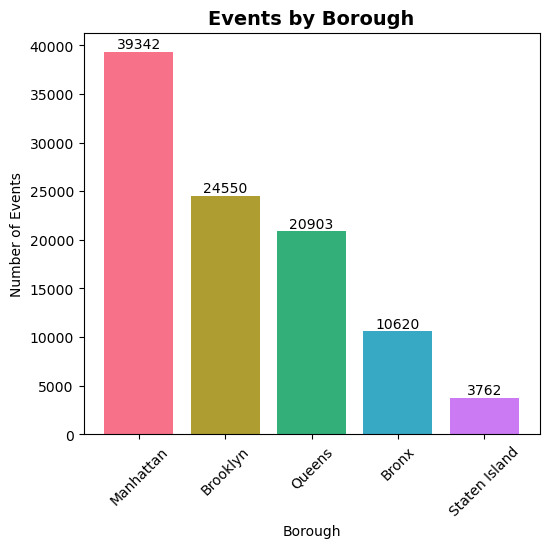

In [61]:
fig = plt.figure(figsize=(20, 24))

plt.subplot(4, 3, 1)
colors_borough = sns.color_palette("husl", len(borough_agg))
plt.bar(borough_agg['Event_Borough'], borough_agg['count'], color=colors_borough)
plt.title('Events by Borough', fontsize=14, fontweight='bold')
plt.xlabel('Borough')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
for i, row in borough_agg.iterrows():
    plt.text(i, row['count'] + 0.5, str(row['count']), ha='center', va='bottom')

In [48]:
type_agg = events_unique.groupBy('Event_Type') \
    .agg(F.count('*').alias('count')) \
    .orderBy(F.col('count').desc()) \
    .toPandas()

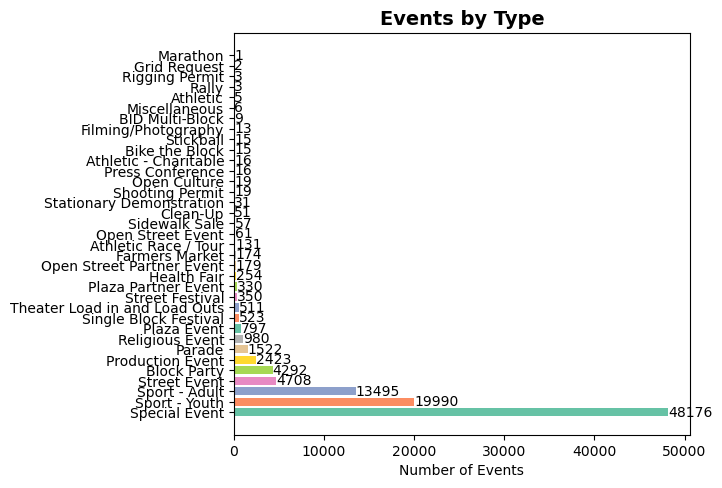

In [63]:
fig = plt.figure(figsize=(20, 24))
plt.subplot(4, 3, 2)
colors_type = sns.color_palette("Set2", len(type_agg))
plt.barh(type_agg['Event_Type'], type_agg['count'], color=colors_type)
plt.title('Events by Type', fontsize=14, fontweight='bold')
plt.xlabel('Number of Events')
for i, row in type_agg.iterrows():
    plt.text(row['count'] + 0.5, i, str(row['count']), ha='left', va='center')

In [49]:
event_name_agg = events_unique.groupBy('Event_Name') \
    .agg(F.count('*').alias('count')) \
    .orderBy(F.col('count').desc()) \
    .limit(15) \
    .toPandas()

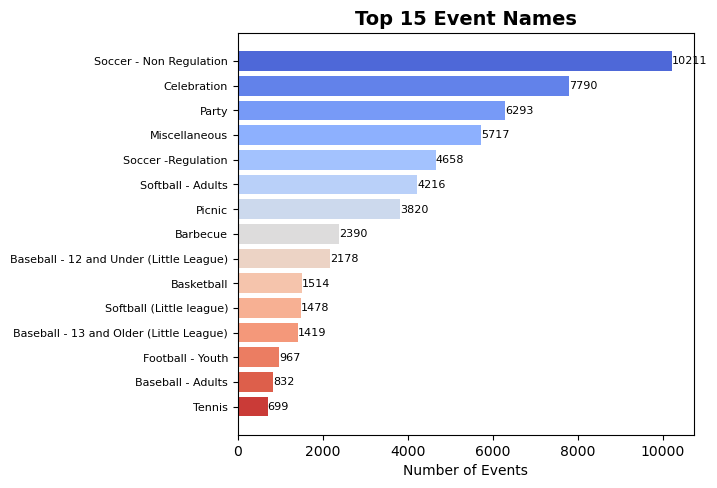

In [65]:
fig = plt.figure(figsize=(20, 24))
plt.subplot(4, 3, 3)
colors_events = sns.color_palette("coolwarm", len(event_name_agg))
plt.barh(range(len(event_name_agg)), event_name_agg['count'], color=colors_events)
plt.yticks(range(len(event_name_agg)), event_name_agg['Event_Name'], fontsize=8)
plt.title('Top 15 Event Names', fontsize=14, fontweight='bold')
plt.xlabel('Number of Events')
plt.gca().invert_yaxis()
for i, row in event_name_agg.iterrows():
    plt.text(row['count'] + 0.1, i, str(row['count']), ha='left', va='center', fontsize=8)

In [50]:
month_agg = events_unique.groupBy('Month') \
    .agg(F.count('*').alias('count')) \
    .orderBy('Month') \
    .toPandas()

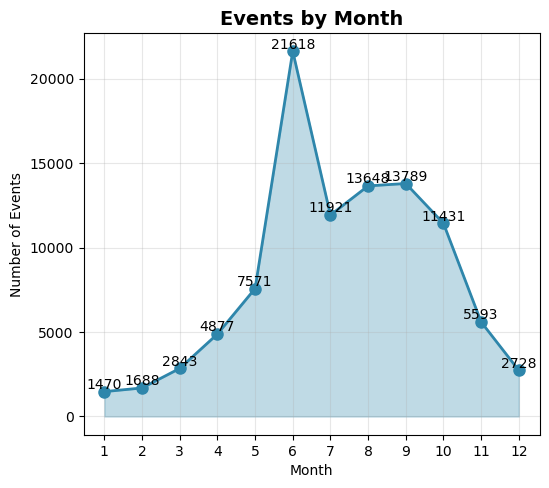

In [71]:
fig = plt.figure(figsize=(20, 24))
plt.subplot(4, 3, 5)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(month_agg['Month'], month_agg['count'], marker='o', linewidth=2, markersize=8, color='#2E86AB')
plt.fill_between(month_agg['Month'], month_agg['count'], alpha=0.3, color='#2E86AB')
plt.title('Events by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.xticks(month_agg['Month'])
plt.grid(True, alpha=0.3)
for _, row in month_agg.iterrows():
    plt.text(row['Month'], row['count'] + 1, str(row['count']), ha='center', va='bottom')

In [51]:
day_agg = events_unique.groupBy('Day_of_Week', 'Day_of_Week_Num') \
    .agg(F.count('*').alias('count')) \
    .orderBy('Day_of_Week_Num') \
    .toPandas()


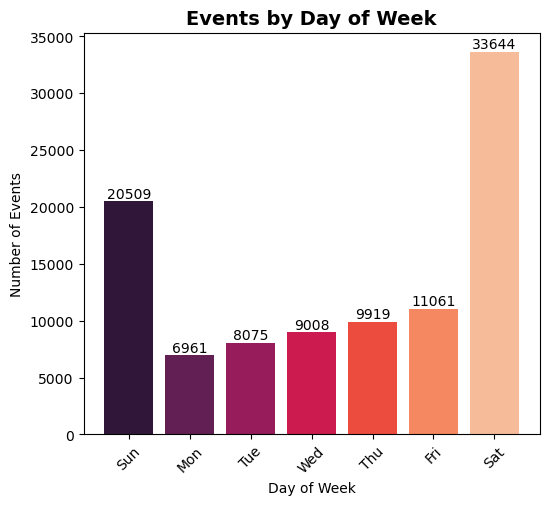

In [72]:
fig = plt.figure(figsize=(20, 24))
plt.subplot(4, 3, 6)
colors_day = sns.color_palette("rocket", len(day_agg))
plt.bar(range(len(day_agg)), day_agg['count'], color=colors_day)
plt.title('Events by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Number of Events')
plt.xticks(range(len(day_agg)), [day[:3] for day in day_agg['Day_of_Week']], rotation=45)
for i, row in day_agg.iterrows():
    plt.text(i, row['count'] + 0.5, str(row['count']), ha='center', va='bottom')

In [52]:
duration_data = events_unique.select('Duration_Hours').toPandas()

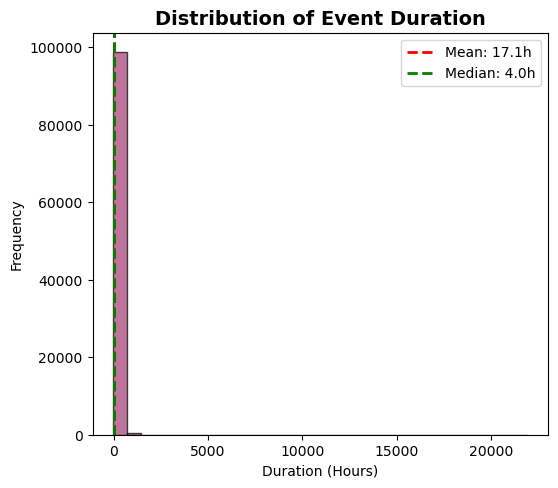

In [73]:
fig = plt.figure(figsize=(20, 24))
plt.subplot(4, 3, 7)
plt.hist(duration_data['Duration_Hours'], bins=30, color='#A23B72', alpha=0.7, edgecolor='black')
plt.title('Distribution of Event Duration', fontsize=14, fontweight='bold')
plt.xlabel('Duration (Hours)')
plt.ylabel('Frequency')
mean_dur = duration_data['Duration_Hours'].mean()
median_dur = duration_data['Duration_Hours'].median()
plt.axvline(mean_dur, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_dur:.1f}h')
plt.axvline(median_dur, color='green', linestyle='--', linewidth=2, label=f'Median: {median_dur:.1f}h')
plt.legend()

In [53]:
hour_agg = events_unique.groupBy('Hour') \
    .agg(F.count('*').alias('count')) \
    .orderBy('Hour') \
    .toPandas()


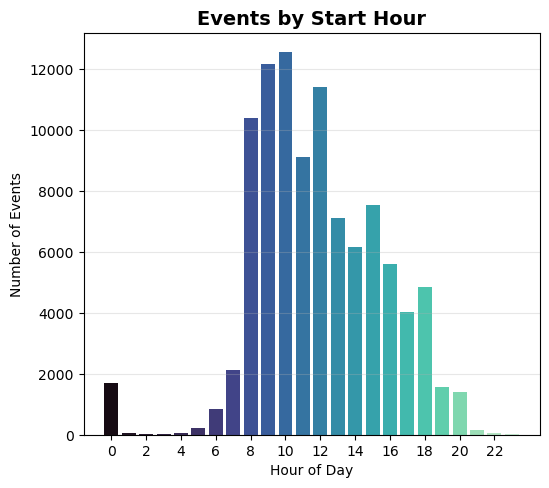

In [74]:
fig = plt.figure(figsize=(20, 24))
plt.subplot(4, 3, 8)
colors_hour = sns.color_palette("mako", 24)
plt.bar(hour_agg['Hour'], hour_agg['count'], color=[colors_hour[h] for h in hour_agg['Hour']])
plt.title('Events by Start Hour', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3, axis='y')

In [54]:
heatmap_agg = events_unique.groupBy('Event_Type', 'Event_Borough') \
    .agg(F.count('*').alias('count')) \
    .toPandas()

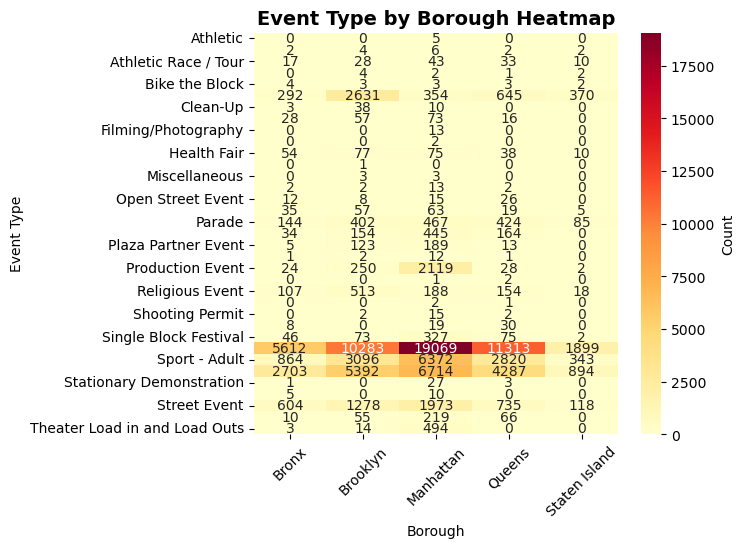

In [79]:
fig = plt.figure(figsize=(20, 24))
plt.subplot(4, 3, 9)
heatmap_pivot = heatmap_agg.pivot(index='Event_Type', columns='Event_Borough', values='count').fillna(0)
sns.heatmap(heatmap_pivot, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Count'})
plt.title('Event Type by Borough Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Borough')
plt.ylabel('Event Type')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [56]:
duration_by_type_agg = df_unievents_uniqueque_spark.groupBy('Event_Type') \
    .agg(F.avg('Duration_Hours').alias('avg_duration')) \
    .orderBy('avg_duration') \
    .toPandas()


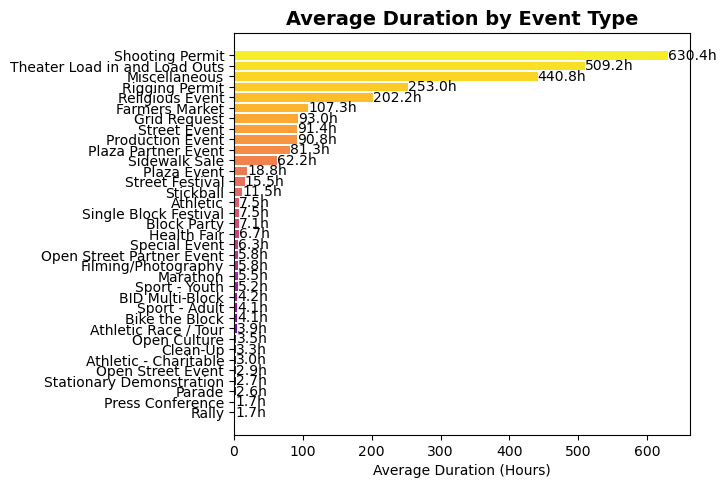

In [80]:
fig = plt.figure(figsize=(20, 24))
plt.subplot(4, 3, 10)
colors_duration = sns.color_palette("plasma", len(duration_by_type_agg))
plt.barh(range(len(duration_by_type_agg)), duration_by_type_agg['avg_duration'], color=colors_duration)
plt.yticks(range(len(duration_by_type_agg)), duration_by_type_agg['Event_Type'])
plt.title('Average Duration by Event Type', fontsize=14, fontweight='bold')
plt.xlabel('Average Duration (Hours)')
for i, row in duration_by_type_agg.iterrows():
    plt.text(row['avg_duration'] + 0.2, i, f'{row["avg_duration"]:.1f}h', ha='left', va='center')

In [57]:
closure_agg = events_unique.groupBy('Street_Closure_Type') \
    .agg(F.count('*').alias('count')) \
    .filter(F.col('Street_Closure_Type').isNotNull()) \
    .orderBy(F.col('count').desc()) \
    .toPandas()

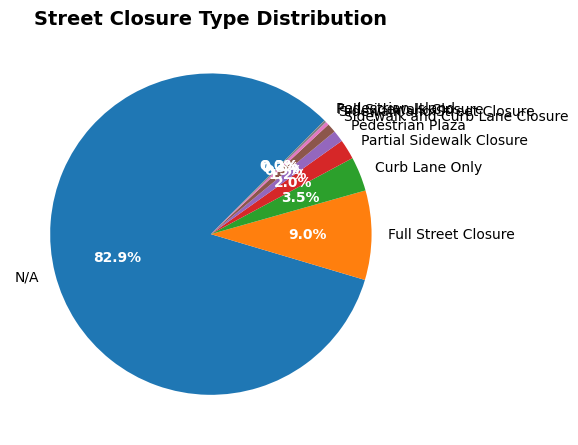

In [81]:
fig = plt.figure(figsize=(20, 24))
plt.subplot(4, 3, 11)
if len(closure_agg) > 0:
    colors_closure = sns.color_palette("tab10", len(closure_agg))
    wedges, texts, autotexts = plt.pie(closure_agg['count'], labels=closure_agg['Street_Closure_Type'], 
                                         autopct='%1.1f%%', colors=colors_closure, startangle=45)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    plt.title('Street Closure Type Distribution', fontsize=14, fontweight='bold')
else:
    plt.text(0.5, 0.5, 'No street closure data', ha='center', va='center', fontsize=12)
    plt.title('Street Closure Type Distribution', fontsize=14, fontweight='bold')